In [23]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder

import optuna

In [24]:

df=pd.read_csv('train_spam.csv')
df['text_type']=df['text_type'].apply(lambda x : 1 if x=='spam' else 0)
df.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


In [25]:
X_train, X_val, y_train, y_val = train_test_split(df.text, df.text_type, test_size=0.2, random_state=42, stratify=df.text_type)

In [19]:
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

In [20]:
pipe = Pipeline([
    ('cv',CountVectorizer(analyzer=text_process)),
    ('tf',TfidfTransformer())])
X_train_tok = pipe.fit_transform(X_train)

In [41]:
X_val_tok=pipe.transform(X_val)

In [27]:
y_pred_proba = model.predict_proba(X_val_tok)[:,1]
sc = roc_auc_score(y_val, y_pred_proba)
sc

0.9848291303173605

In [28]:
study = optuna.create_study(study_name="my_first_study", direction="maximize")
def objective(trial):
    params = {
          'alpha': trial.suggest_float('alpha', 1e-7, 1000, log=True),
             }

    model = MultinomialNB(**params)
    model.fit(X_train_tok, y_train)
    
    y_pred_proba = model.predict_proba(X_val_tok)[:,1:]
    sc = roc_auc_score(y_val, y_pred_proba)
    
    return sc

study.optimize(objective, n_trials=1000)

[I 2024-05-03 23:43:09,543] A new study created in memory with name: my_first_study
[I 2024-05-03 23:43:09,567] Trial 0 finished with value: 0.9744085175645769 and parameters: {'alpha': 0.009733233908560367}. Best is trial 0 with value: 0.9744085175645769.
[I 2024-05-03 23:43:09,576] Trial 1 finished with value: 0.8432510372353441 and parameters: {'alpha': 997.7915430644751}. Best is trial 0 with value: 0.9744085175645769.
[I 2024-05-03 23:43:09,587] Trial 2 finished with value: 0.9626586213334252 and parameters: {'alpha': 7.089352821263288e-05}. Best is trial 0 with value: 0.9744085175645769.
[I 2024-05-03 23:43:09,597] Trial 3 finished with value: 0.9580696819144945 and parameters: {'alpha': 3.7824605124561265e-06}. Best is trial 0 with value: 0.9744085175645769.
[I 2024-05-03 23:43:09,607] Trial 4 finished with value: 0.9580692287754188 and parameters: {'alpha': 3.7797166196347007e-06}. Best is trial 0 with value: 0.9744085175645769.
[I 2024-05-03 23:43:09,617] Trial 5 finished with

In [10]:
study = optuna.create_study(study_name="my_first_study", direction="maximize")
def objective(trial, train_pool=X_train_tok, val_pool=X_val_tok):
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)
    max_features = trial.suggest_categorical(name="max_features", choices=['log2', 'sqrt']) 
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(**params)
    model.fit(train_pool,y_train)
    
    y_pred_proba = model.predict_proba(val_pool)[:,1]
    sc = roc_auc_score(y_val, y_pred_proba)
    
    return sc

study.optimize(objective, n_trials=100)

[I 2024-05-03 21:21:48,870] A new study created in memory with name: my_first_study
[I 2024-05-03 21:21:53,822] Trial 0 finished with value: 0.9782094481309827 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9782094481309827.
[I 2024-05-03 21:21:58,314] Trial 1 finished with value: 0.9741008361322223 and parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 70, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9782094481309827.
[I 2024-05-03 21:22:00,850] Trial 2 finished with value: 0.9759321977063912 and parameters: {'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9782094481309827.
[I 2024-05-03 21:22:01,725] Trial 3 finished with value: 0.9681266505590829 and parameters: {'n_estimators': 500, 'max_features': 'log2', 'max_depth': 30, 'min_s

In [27]:
study = optuna.create_study(study_name="my_first_study", direction="maximize")
def objective(trial):
    params = {
        'loss': 'modified_huber',
        'penalty': trial.suggest_categorical("penalty", ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-7, 1000, log=True),
        'n_jobs': -1,
        'random_state': 42,
        
             }
    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = trial.suggest_float('l1_ratio', 1e-7, 1, log=True)

    model = SGDClassifier(**params)
    model.fit(X_train_tok, y_train)
    
    y_pred_proba = model.predict_proba(X_val_tok)[:,1:]
    sc = roc_auc_score(y_val, y_pred_proba)
    
    return sc

study.optimize(objective, n_trials=1000)

[I 2024-05-03 21:52:09,086] A new study created in memory with name: my_first_study
[I 2024-05-03 21:52:09,106] Trial 0 finished with value: 0.9819981439423463 and parameters: {'penalty': 'l2', 'alpha': 0.00039247693265917575}. Best is trial 0 with value: 0.9819981439423463.
[I 2024-05-03 21:52:09,154] Trial 1 finished with value: 0.9809434627438115 and parameters: {'penalty': 'elasticnet', 'alpha': 0.00048348049137436367, 'l1_ratio': 0.004039289848526778}. Best is trial 0 with value: 0.9819981439423463.
[I 2024-05-03 21:52:09,182] Trial 2 finished with value: 0.5 and parameters: {'penalty': 'l1', 'alpha': 1.6176824143879258}. Best is trial 0 with value: 0.9819981439423463.
[I 2024-05-03 21:52:09,203] Trial 3 finished with value: 0.5 and parameters: {'penalty': 'l1', 'alpha': 141.5020547177898}. Best is trial 0 with value: 0.9819981439423463.
[I 2024-05-03 21:52:09,219] Trial 4 finished with value: 0.9607812661430796 and parameters: {'penalty': 'l2', 'alpha': 0.007059946248048241}. Bes

In [29]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  1000
Best trial:
  Value:  0.977299998006188
  Params: 
    alpha: 0.06546424657086591


In [30]:
df_test=pd.read_csv('test_spam.csv')
df_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [31]:
X_test_tok = pipe.transform(df_test.text)

In [40]:
model = SGDClassifier(loss = 'modified_huber',
                      penalty = 'elasticnet',
                      alpha = 0.00011294591375135237,
                      l1_ratio = 0.000893485954362624,
                      n_jobs= -1,
                      random_state = 42)
model.fit(X_train_tok, y_train)
df_test['score'] = model.predict_proba(X_test_tok)[:,1:]
df_test.to_csv('answer.csv')

In [39]:
df_test.iloc[94]

text     join our group 🍆🔞🔞🔞🔞🔞🔞🔞🔞🔞🔞
score                      0.794396
Name: 94, dtype: object

<Axes: >

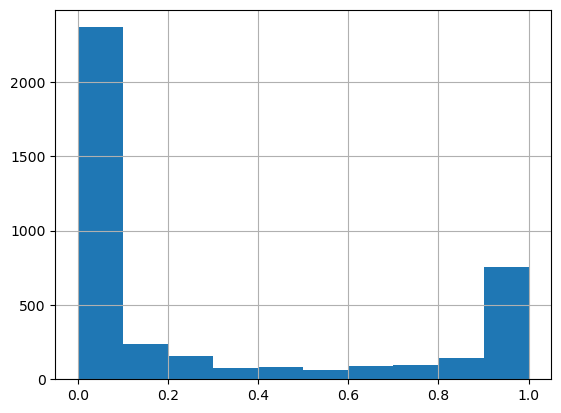

In [34]:
alpha = 0.06551677334710446
model = MultinomialNB(alpha=alpha)
model.fit(X_train_tok, y_train)
df_test['score'] = model.predict_proba(X_test_tok)[:,1:]
df_test.score.hist()

In [35]:
df_test.iloc[94]

text     join our group 🍆🔞🔞🔞🔞🔞🔞🔞🔞🔞🔞
score                      0.461908
Name: 94, dtype: object

<Axes: >

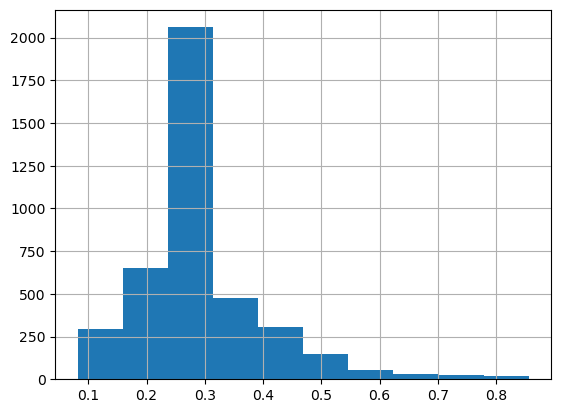

In [36]:
model = RandomForestClassifier(n_estimators = 400,
                              max_features = 'log2',
                              max_depth = 110,
                              min_samples_split = 6,
                              min_samples_leaf = 1)
model.fit(X_train_tok, y_train)
df_test['score'] = model.predict_proba(X_test_tok)[:,1:]
df_test.score.hist()

In [37]:
df_test.iloc[94]

text     join our group 🍆🔞🔞🔞🔞🔞🔞🔞🔞🔞🔞
score                      0.282104
Name: 94, dtype: object

In [11]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials:  100
Best trial:
  Value:  0.9895415501344011
  Params: 
    n_estimators: 400
    max_features: log2
    max_depth: 110
    min_samples_split: 6
    min_samples_leaf: 1
